In [1]:
# only run this if you have not cloned it or you need to fetch the latest commits
! if [ -d cytounet ]; then pushd cytounet && git fetch origin && git reset --hard origin/master && git clean -fd && popd; else git clone https://github.com/Nelson-Gon/cytounet.git; fi

Cloning into 'cytounet'...
remote: Enumerating objects: 1812, done.
remote: Total 1812 (delta 0), reused 0 (delta 0), pack-reused 1812
Receiving objects: 100% (1812/1812), 178.10 MiB | 44.28 MiB/s, done.
Resolving deltas: 100% (827/827), done.


In [2]:
%cd cytounet 

/content/cytounet


In [3]:
from cytounet.model import *
from cytounet.augmentation import *
from cytounet.data import *
from cytounet.post_model import *


In [ ]:
# threshold chosen based on histogram and visual view in Fiji
# same procedure for the validation data set
# thresholded = threshold_images("examples/original_data/a549/train/fluorescent_masks",thresh_val=83)

In [5]:
x_train = read_images("examples/original_data/a549/train/images")
y_train = read_images("examples/original_data/a549/train/masks")
x_test = read_images("examples/original_data/a549/test/images")

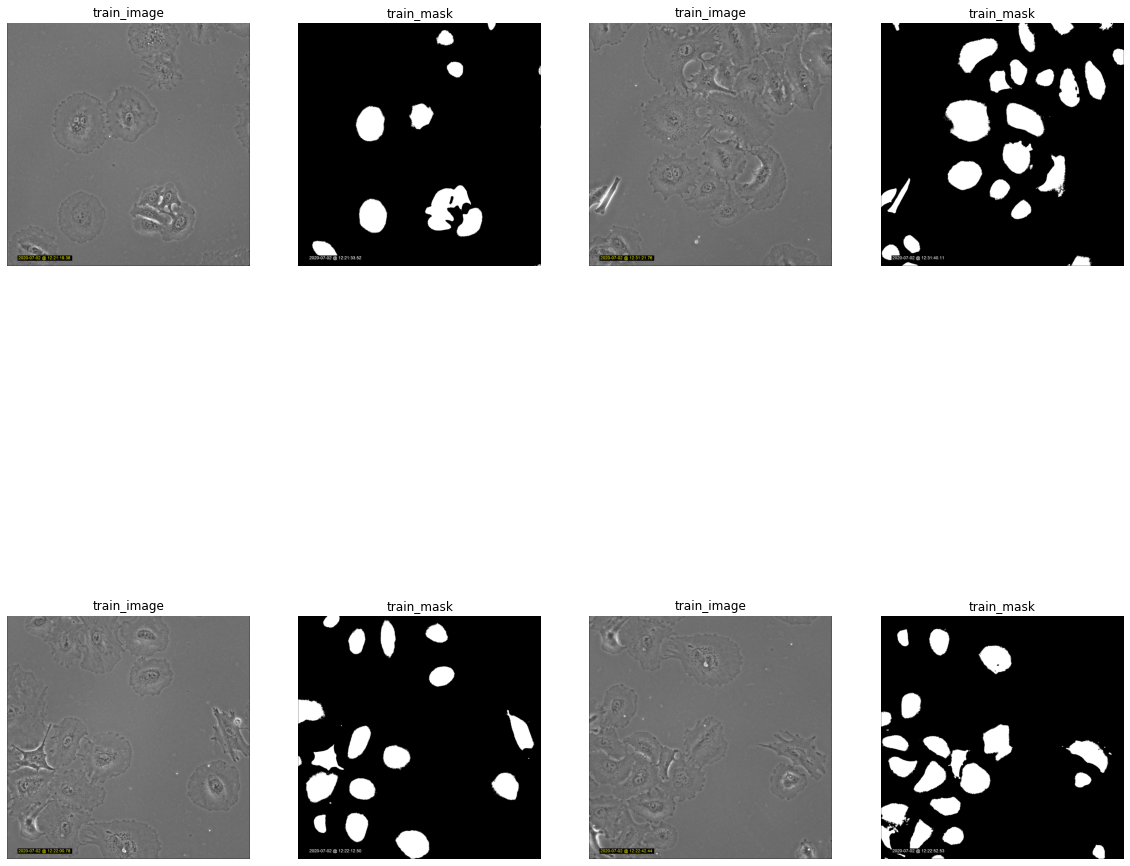

In [6]:
show_images(x_train, y_train, number =4, titles = ['train_image', 'train_mask'])

In [7]:
data_generator_args =  dict(rotation_range=0.1,
                      rescale = 1./255,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [8]:
%cd examples/original_data/a549/

/content/cytounet/examples/original_data/a549


In [9]:
my_generator = generate_train_data(32,'train', 'images','masks',data_generator_args,save_to_dir =None, seed= 2,target_size = (512, 512))


In [10]:
valid_generator = generate_validation_data(32, "validation", "images", "masks", data_generator_args, save_to_dir=None, seed=12,
                                           target_size = (512, 512))

In [14]:
model = unet(learning_rate=1e-4, input_size=(512, 512, 1), metrics =dice_coef,
             loss=dice_coef_loss,
             use_regularizer = False, layered_conv=True)
model_single_layered = unet(learning_rate=1e-4, input_size=(512, 512, 1), metrics =dice_coef,
             loss=dice_coef_loss,
             use_regularizer = False, layered_conv=False)

In [12]:
model.summary()

Model: "unet_complex"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
model_single_layered.summary()

Model: "unet_complex"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 512, 512, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 512, 512, 16) 64          conv2d_67[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 256, 256, 16) 0           batch_normalization_36[0][0]     
_______________________________________________________________________________________

In [17]:
history = train(model_object=model_single_layered, train_generator=my_generator, epochs = 10, steps_per_epoch= 250 , batch_size = 16)

Epoch 1/10
250/250 [==============================] - 237s 952ms/step - loss: 0.3632 - dice_coef: 0.6368
Epoch 2/10
250/250 [==============================] - 237s 950ms/step - loss: 0.2666 - dice_coef: 0.7334
Epoch 3/10
250/250 [==============================] - 238s 954ms/step - loss: 0.2078 - dice_coef: 0.7922
Epoch 4/10
250/250 [==============================] - 237s 949ms/step - loss: 0.1633 - dice_coef: 0.8367
Epoch 5/10
250/250 [==============================] - 240s 960ms/step - loss: 0.1331 - dice_coef: 0.8669
Epoch 6/10
250/250 [==============================] - 238s 953ms/step - loss: 0.1116 - dice_coef: 0.8884
Epoch 7/10
250/250 [==============================] - 240s 959ms/step - loss: 0.0970 - dice_coef: 0.9030
Epoch 8/10
250/250 [==============================] - 239s 958ms/step - loss: 0.0855 - dice_coef: 0.9145
Epoch 9/10
250/250 [==============================] - 238s 951ms/step - loss: 0.0776 - dice_coef: 0.9224
Epoch 10/10
250/250 [==============================] - 

In [21]:
model.save("a549_scratch_github.hdf5")

In [22]:
results = predict(test_path="test",model_weights= "a549_scratch_github.hdf5",train_seed = 12,custom_loss = {'dice_coef': dice_coef,
                                               'dice_coef_loss': dice_coef_loss}, target_size = (512, 512))

Found 10 images belonging to 1 classes.
['images/img_1.tif', 'images/img_10.tif', 'images/img_2.tif', 'images/img_3.tif', 'images/img_4.tif', 'images/img_5.tif', 'images/img_6.tif', 'images/img_7.tif', 'images/img_8.tif', 'images/img_9.tif']


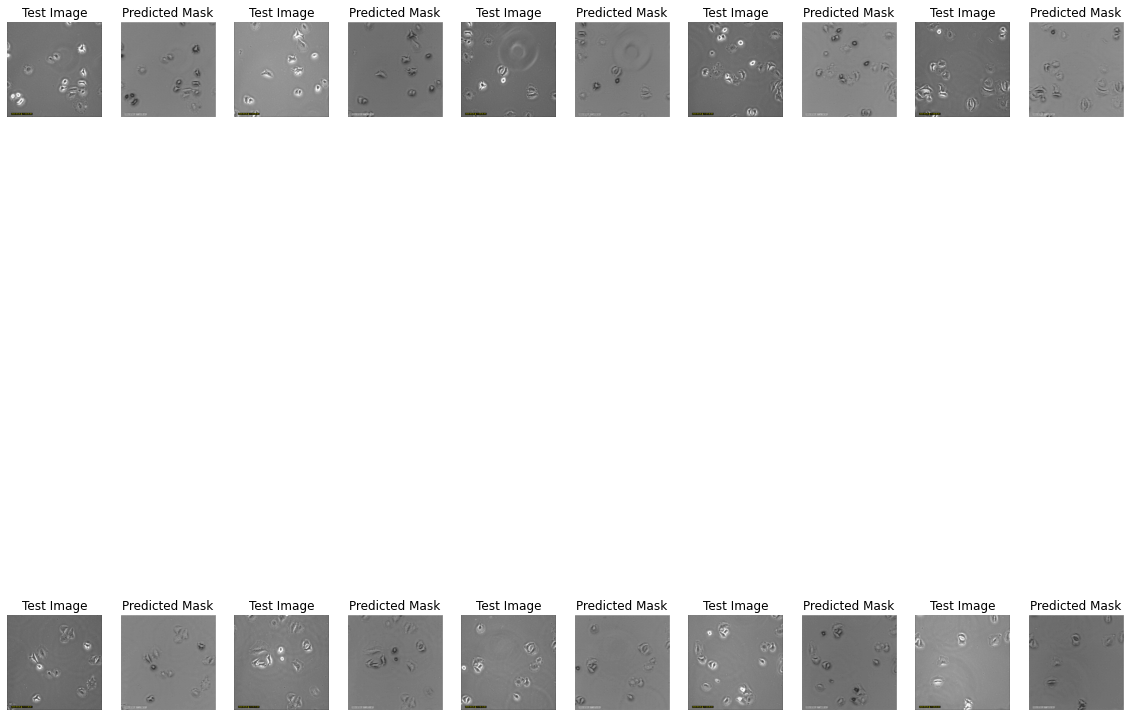

In [23]:
show_images(x_test, results,number = 10, titles=['Test Image', 'Predicted Mask'], figure_size=(20,20))

In [25]:
# when training from scratch, provide both x and y. Otherwise, provide a generator eg my_generator
finetuned = finetune(pretrained_weights="a549_scratch_github.hdf5",
                   model_object=model_single_layered, train_generator=my_generator, epochs = 5, steps_per_epoch= 100 , batch_size = 8,
                verbose=1,   validation_data=valid_generator, 
                 validation_steps = 20, monitor_metric='val_loss')

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.0676 - dice_coef: 0.9324Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
['images/img_1.tif', 'images/img_10.tif', 'images/img_2.tif', 'images/img_3.tif', 'images/img_4.tif', 'images/img_5.tif', 'images/img_6.tif', 'images/img_7.tif', 'images/img_8.tif', 'images/img_9.tif']
['masks/msk_1.tif', 'masks/msk_10.tif', 'masks/msk_2.tif', 'masks/msk_3.tif', 'masks/msk_4.tif', 'masks/msk_5.tif', 'masks/msk_6.tif', 'masks/msk_7.tif', 'masks/msk_8.tif', 'masks/msk_9.tif']
100/100 [==============================] - 114s 1s/step - loss: 0.0676 - dice_coef: 0.9324 - val_loss: 0.7326 - val_dice_coef: 0.2674

Epoch 00001: val_loss improved from inf to 0.73257, saving model to a549_scratch_github.hdf5
Epoch 2/5
100/100 [==============================] - 114s 1s/step - loss: 0.0727 - dice_coef: 0.9273 - val_loss: 0.6789 - val_dice_coef: 0.3211

Epoch 00002: val_loss improved from 0.73257 to 0.67892, sa

In [26]:
results_fine_tuned = predict(test_path="test",model_weights= "a549_scratch_github.hdf5",train_seed = 12,custom_loss = {'dice_coef': dice_coef,
                                               'dice_coef_loss': dice_coef_loss}, target_size = (512, 512))

Found 10 images belonging to 1 classes.
['images/img_1.tif', 'images/img_10.tif', 'images/img_2.tif', 'images/img_3.tif', 'images/img_4.tif', 'images/img_5.tif', 'images/img_6.tif', 'images/img_7.tif', 'images/img_8.tif', 'images/img_9.tif']


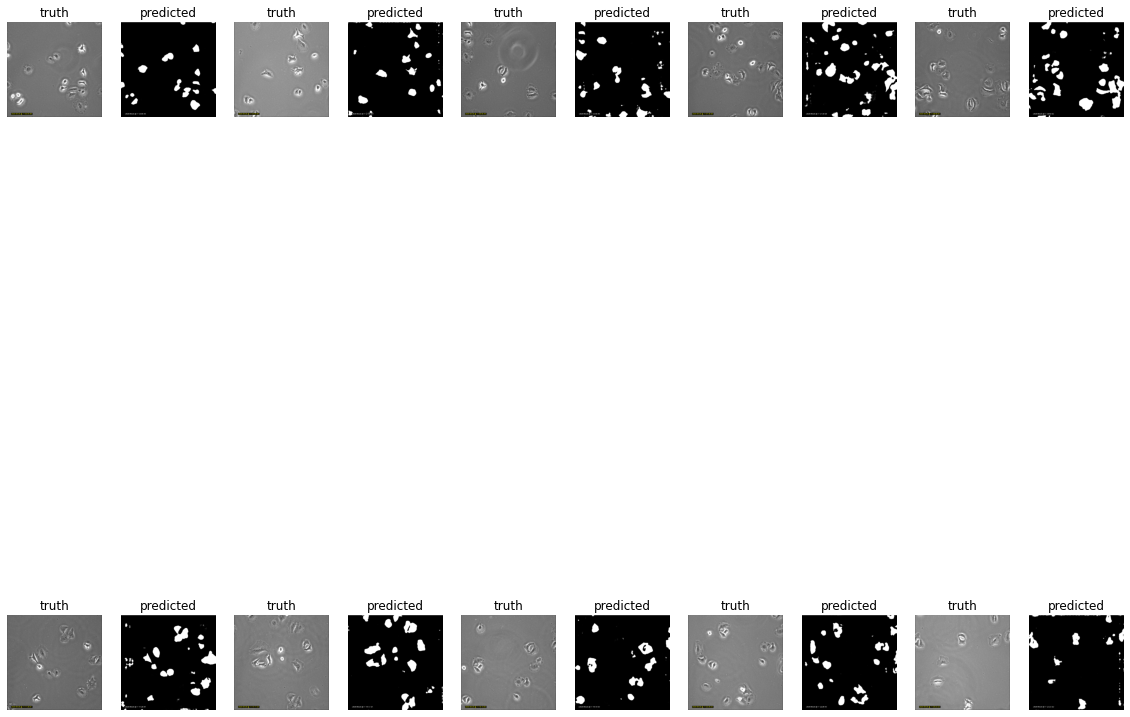

In [27]:
show_images(x_test, results_fine_tuned,number = 10, titles=['truth', 'predicted'], figure_size=(20,20))

In [28]:

res_resized = resize_images(results_fine_tuned, (1200, 1200,1))

In [29]:
!mkdir predictions

In [31]:
save_predictions("predictions", res_resized, image_prefix="prediction_sample_",image_suffix="png")

In [32]:
predictions = read_image_spec("predictions", "png", load_format="pred*", verbose=False)

In [33]:
contours, areas, edges = find_contours(predictions, return_edges=True)

Returning 4 images as requested


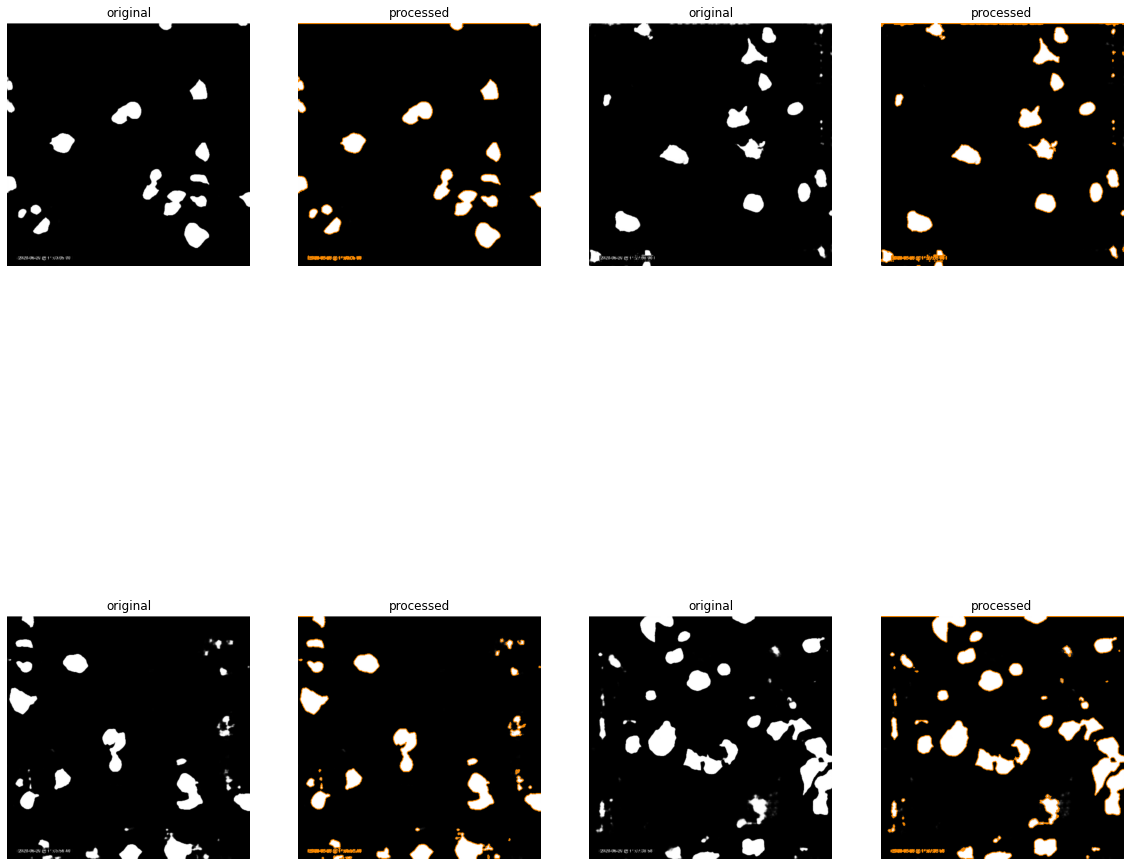

In [34]:
areas_plot, original_images = draw_contours(areas, contours, predictions, 0,
                                      number=4, figure_size=(20, 20), show_text=False)